# Interactive simulation

This notebook is only for designing experiments. Not bulk runs.

In [20]:
print("Hello, world!")

Hello, world!


In [21]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import pandas as pd

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [22]:
# Figure configurations
mpl.rc('text', usetex=False)
mpl.rcParams['figure.dpi'] = 150

In [36]:
sp = ice.spins()

# Initialize some parameters
trapSep = 10*ureg.um
particleRadius = 5*ureg.um
totalTime = 120*ureg.s

#L = trapSep+4*(particleRadius+.5*ureg.um)*np.cos(np.pi/4)
L = 30*ureg.um
N = 10

# Create simulation objects
sp.create_lattice("square",[N,N],lattice_constant=L, border="periodic")

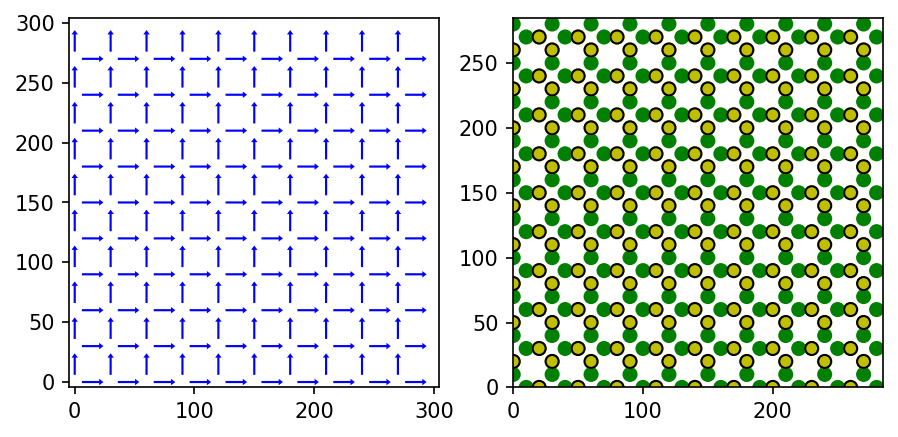

In [37]:
particle = ice.particle(radius = particleRadius,
             susceptibility = 0.0576,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

trap = ice.trap(trap_sep = trapSep,
               height = 4*ureg.pN*ureg.nm,
               stiffness = 1e-3*ureg.pN/ureg.nm)

col = ice.colloidal_ice(sp, particle, trap,
                        height_spread = 0, 
                        susceptibility_spread = 0.1,
                        periodic = True)

f, (ax1,ax2) = plt.subplots(1,2,figsize = (7,3.5))
sp.display(ax1)
col.display(ax2)

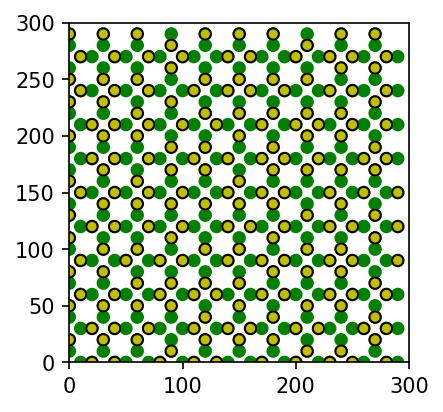

In [38]:
col.randomize()
col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L

f, (ax2) = plt.subplots(1,1,figsize = (3,3))
col.display(ax2)

In [39]:
# Prepare the simulation
framespersec = 20*ureg.Hz;
dt = 10*ureg.ms

world = ice.world(
    field = 5*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um)


col.simulation(world,
             name = "test",
             include_timestamp = False,
             targetdir = r".",
             framerate = framespersec,
             timestep = dt,
             run_time = totalTime,
             output = ["x","y","z","mux","muy","muz"])

In [40]:
# Play with the simulation parameters directly

col.sim.field.fieldx = "v_Bmag*sin(PI/3)*time/60e6*(time<60e6)+v_Bmag*sin(PI/3)*(time>=60e6)"
col.sim.field.fieldy = "0"
col.sim.field.fieldz = "v_Bmag*cos(PI/3)*time/60e6*(time<60e6)+v_Bmag*cos(PI/3)*(time>=60e6)"


col.run_simulation()

In [41]:
col.load_simulation()
col.trj.to_csv('../data/trj.csv')
print('Saved trj')
trj = ice.get_ice_trj(col.trj, bounds = col.bnd)
trj.to_csv('../data/ctrj.csv')
print('Saved centered trj')

scanning file


  0%|          | 0/39265072 [00:00<?, ?it/s]

Saved trj
Saved centered trj


(-10.0, 10.0)

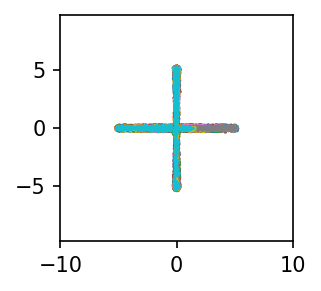

In [42]:
frames = trj.index.get_level_values("frame").unique()
plt.figure(figsize=(2,2))
for i, trj_i in trj.loc[idx[frames[:],:],:].groupby("id"):
    plt.plot(np.array(trj_i.cx), np.array(trj_i.cy))

plt.axis("equal")
plt.xlim(-10,10)
plt.ylim(-10,10)